<a href="https://colab.research.google.com/github/trang-0387/CS114.K21/blob/master/CaseStudy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Thành viên nhóm:**
* Vũ Thị Trang   -      18520387
* Tăng Năng Chung   -   18520536
* Lê Thị Ngọc Phương  - 18521273 

# **Sarcasm Detection**

1. **Mô tả bài toán**: Input: 1 headline của 1 bài báo Output: headline châm biếm hoặc chính thống
2. **Cách thu thập dữ liệu**: Thu thập các headlines từ 2 trang web: HuffPost và TheOnion
* HuffPost: trang báo chuyên về các tin tức chính thống
* TheOnion: trang báo chuyên về các tin châm biếm
* Training Dataset:sử dụng dataset đã có trên kaggle
  * Dataset:
    * article_link: liên kết đến các bài báo
    * headline: tiêu đề bài báo
    * is_sacastic: 1: châm biếm và 0: chính thống
  * Testing Dataset: sử dụng công cụ Scraper để crawl data từ hai trang web trên.
    * Dataset: headline
  * Số lượng headlines cần thu thập của Testing Dataset: 1000 sarcastic headlines và 1000 not sarcatic headlines.

# **Import các thư viện cần thiết**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Lấy dataset trên kaggle**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (6).json


{'kaggle.json': b'{"username":"trangvuthi","key":"b3d92781161ece64cd3852bd9abd8167"}'}

In [3]:
!pip install kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets list -s sarcasm

ref                                                      title                                               size  lastUpdated          downloadCount  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
danofer/sarcasm                                          Sarcasm on Reddit                                  216MB  2018-05-27 08:19:04           4177  
rmisra/news-headlines-dataset-for-sarcasm-detection      News Headlines Dataset For Sarcasm Detection         3MB  2019-07-03 23:52:57           9689  
rmisra/news-category-dataset                             News Category Dataset                               25MB  2018-12-02 04:09:45          11519  
sherinclaudia/sarcastic-comments-on-reddit               Sarcastic Comments - REDDIT                        106MB  2019-01-30 14:41:53           1930  
rmisra/clothing-fit-dataset-for-size-recommendation      Clothing Fit Dataset for Size R

In [6]:
!kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

news-headlines-dataset-for-sarcasm-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip news-headlines-dataset-for-sarcasm-detection.zip

Archive:  news-headlines-dataset-for-sarcasm-detection.zip
replace Sarcasm_Headlines_Dataset.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Sarcasm_Headlines_Dataset.json  
replace Sarcasm_Headlines_Dataset_v2.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Sarcasm_Headlines_Dataset_v2.json  


* Dataset gồm có hai file là Sarcasm_Headlines_Dataset.json và file Sarcasm_Headlines_Dataset_v2.json

* Đọc cả hai file thông qua thư viện pandas với hàm pd.read_json()

* Một dòng của dataframe được lưu trên mỗi dòng của json nên phải gán tham số lines = True

In [8]:
f1=pd.read_json('Sarcasm_Headlines_Dataset.json',lines=True)
f2=pd.read_json('Sarcasm_Headlines_Dataset_v2.json',lines=True)

**Ghép nối 2 cấu trúc dữ liệu pandas f1 và f2**

In [9]:
df=pd.concat([f1,f2],axis=0)
df

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
28614,https://www.theonion.com/jews-to-celebrate-ros...,jews to celebrate rosh hashasha or something,1
28615,https://local.theonion.com/internal-affairs-in...,internal affairs investigator disappointed con...,1
28616,https://www.huffingtonpost.com/entry/andrew-ah...,the most beautiful acceptance speech this week...,0
28617,https://www.theonion.com/mars-probe-destroyed-...,mars probe destroyed by orbiting spielberg-gat...,1


Dataset có ba cột:
  * article_link
  * headline
  * is_sarcastic: 1 (sarcastic headline) và 0: (not sarcastic headline)
  
Dataset sau khi ghép có 55328 headline 

# **Xử lý dữ liệu**

**Xóa cột article_link vì không cần thiết**

In [10]:
df=df.drop('article_link',axis=1)
df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
28614,jews to celebrate rosh hashasha or something,1
28615,internal affairs investigator disappointed con...,1
28616,the most beautiful acceptance speech this week...,0
28617,mars probe destroyed by orbiting spielberg-gat...,1


**Xóa bỏ các headline trùng nhau**

In [11]:
df=df.drop_duplicates('headline')
df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
28497,tyson holds contest to let fans submit new ide...,1
28509,increasingly cocky bernie sanders announces he...,1
28520,cash-strapped zuckerberg forced to sell 11 mil...,1
28544,grocery store bar actually has great little ha...,1


**Dataset sau khi loại bỏ các headline trùng nhau là: 28503 headline**

**Xóa bỏ những char không cần thiết**

In [12]:
df['headline'] = df['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,headline,is_sarcastic
0,former versace store clerk sues over secret b...,0
1,the roseanne revival catches up to our thorn...,0
2,mom starting to fear son s web series closest ...,1
3,boehner just wants wife to listen not come up...,1
4,j k rowling wishes snape happy birthday in th...,0
...,...,...
28497,tyson holds contest to let fans submit new ide...,1
28509,increasingly cocky bernie sanders announces he...,1
28520,cash strapped zuckerberg forced to sell mil...,1
28544,grocery store bar actually has great little ha...,1


**Sử dụng seaborn vẽ biểu đồ**

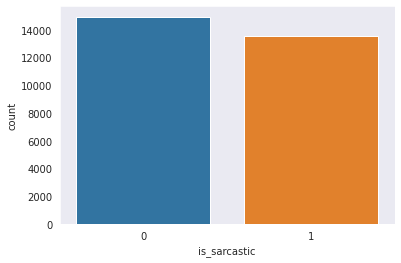

In [13]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [14]:
len(df[df['is_sarcastic']==1])

13552

In [15]:
len(df[df['is_sarcastic']==0])

14951

**Qua biểu đồ ta thấy số lượng sarcastic headlines gần bằng so với số lượng not sarcastic headlines (chênh nhau 1399 headlines) -> dataset khá cân bằng**

**Loại bỏ các stop words**

In [16]:
tf = TfidfVectorizer(stop_words="english")
feature = tf.fit_transform(df['headline'])

In [17]:
label = df['is_sarcastic']

# **Load dataset đã thu thập**

* Dataset được thu thập từ hai trang HuffPost (chuyên tin tức chính thống) và TheOnion (chuyên tin tức châm biểm)

* Việc thu thập dữ liệu từ hai trang báo trên đều dựa vào công cụ Data Scraper được google chrome hỗ trợ

Load dataset tự thu thập từ trang TheOnion

In [18]:
names=['headlines','is_sarcastic']
data1=pd.read_csv('TheOnion.csv',encoding='unicode-escape',names=names)
data1['is_sarcastic']=1
data1

,headlines,is_sarcastic
0,Georgia Secretary Of State Vows To Investigate...,1
1,Congress Announces Willingness To Offer Black ...,1
2,Democratic Leaders Announce That Theyve Learn...,1
3,"She Needs A Bible Now, FuckwadYes, Its For ...",1
4,DNC To Streamline Fundraising By Cutting Out U...,1
...,...,...
995,Amazing Detail: Every Game In MLB The Show W...,1
996,Everything You Need To Know About Nioh 2,1
997,Amazing Collaboration: NASA Is Working With Ni...,1
998,Amazing News Gamers: Everyone Is Having A Grea...,1


Load dataset tự thu thập từ trang HuffPost

In [19]:
names=['headlines','is_sarcastic']
data2=pd.read_csv('HuffPost.csv',encoding='unicode-escape',names=names)
data2['is_sarcastic']=0
data2

,headlines,is_sarcastic
0,Trump Fires U.S. Attorney Who Led Probes Of Th...,0
1,6 Staffers Working On Trump's Tulsa Rally Test...,0
2,Community Wants Answers After LA Deputies Fata...,0
3,Police Arrest Peaceful Protester Sitting Alone...,0
4,Joe Biden Raised More Money Than Donald Trump ...,0
...,...,...
995,Bronx Rep. Eliot Engels Hot Mic Moment Gives ...,0
996,Fauci Says Meetings With Trump On Coronavirus ...,0
997,Bronx Rep. Eliot Engels Hot Mic Moment Gives ...,0
998,Ithaca Could Be The First U.S. City To Move Fo...,0


**Nối hai dataframe**

In [20]:
data=pd.concat([data1,data2],axis=0)
data

,headlines,is_sarcastic
0,Georgia Secretary Of State Vows To Investigate...,1
1,Congress Announces Willingness To Offer Black ...,1
2,Democratic Leaders Announce That Theyve Learn...,1
3,"She Needs A Bible Now, FuckwadYes, Its For ...",1
4,DNC To Streamline Fundraising By Cutting Out U...,1
...,...,...
995,Bronx Rep. Eliot Engels Hot Mic Moment Gives ...,0
996,Fauci Says Meetings With Trump On Coronavirus ...,0
997,Bronx Rep. Eliot Engels Hot Mic Moment Gives ...,0
998,Ithaca Could Be The First U.S. City To Move Fo...,0


# **Xử lý dataset tự thu thập**

Loại bỏ các kí tự đặc biệt và số

In [21]:
import string

In [22]:
def xuli_headline(headline_):
  headline_=''.join(ch for ch in headline_ if ch in (string.ascii_letters+string.digits+' '))
  headline_=headline_.lower()
  headline_=headline_.strip()
  return headline_

In [23]:
data_final=[]
for headline_ in data['headlines']:
  data_final.append(xuli_headline(headline_))
data_final

['georgia secretary of state vows to investigate why some residents forced to wait 2 centuries to vote',
 'congress announces willingness to offer black lives matter protesters holiday or statue',
 'democratic leaders announce that theyve learned the words systemic racism',
 'she needs a bible now fuckwadyes its for an epic clapback yells panicked pelosi aide into phone',
 'dnc to streamline fundraising by cutting out unnecessary cost of campaigns candidates',
 'pros and cons of voting by mail',
 'biden campaign email trails off halfway through',
 'biden campaign considering using the internet to attract voters',
 'nancy pelosi assures democratic reps they dont need to try being productive during stressful pandemic',
 'obama im so proud to endorse joe bidenthats who they went with huhfor president',
 'it was for uh medical reasons says doctor to boris johnson explaining why they had to give him haircut',
 'i congratulate joe biden a very decent man says bernie sanders in unprovoked att

Loại bỏ stop words

In [24]:
data_final=tf.transform(data_final)

In [25]:
data_final

<2000x25608 sparse matrix of type '<class 'numpy.float64'>'
	with 13757 stored elements in Compressed Sparse Row format>

# **Phân chia tập dữ liệu cho train-test-validation set**

* Train-Validation dataset: dataset trên Kaggle với tỉ lệ 8:2
* Test dataset: dataset tự thu thập

In [26]:
x_train, x_valid, y_train, y_valid = train_test_split(feature,label,test_size=0.2,random_state=42)

# **Traning model**


Sử dụng accuracy_score để đánh giá model. 

accuracy_score là tỷ lệ những headline được dự đoán đúng. 

In [41]:
score= {}

**Model 1:  Logistic Regression**

In [ ]:
model1 = LogisticRegression()
model1.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predict1= model1.predict(x_valid)

In [ ]:
score['LR']=accuracy_score(y_valid,predict1)

In [ ]:
print(accuracy_score(y_valid,predict1))

0.795474478161726


**Model 2: LinearSVC**

In [ ]:
model2 = LinearSVC()
model2.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
predict2 = model2.predict(x_valid)

In [ ]:
score['LSVC']=accuracy_score(y_valid,predict2)

In [ ]:
print(accuracy_score(y_valid,predict2))

0.7926679529907034


**Model 3: RandomForestClassifier**

In [ ]:
model3 = RandomForestClassifier()
model3.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
predict3 = model3.predict(x_valid)

In [ ]:
score['RFC']=accuracy_score(y_valid,predict3)

In [ ]:
print(accuracy_score(y_valid,predict3))

0.7619715839326434


**Model 4: Naive Bayes**

In [27]:
model4 = BernoulliNB()
model4.fit(x_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [28]:
predict4 = model4.predict(x_valid)

In [42]:
score['BNB']=accuracy_score(y_valid,predict4)

In [30]:
print(accuracy_score(y_valid,predict4))

0.8109103666023505


**Model 5: Support Vector Machine**

In [ ]:
model5=SVC()
model5.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
predict5 = model5.predict(x_valid)

In [ ]:
score['SVM']=accuracy_score(y_valid,predict5)

In [ ]:
print(accuracy_score(y_valid,predict5))

0.8005613050342045


# **Tổng kết score model**

In [ ]:
S=pd.DataFrame()
S['model']=score.keys()
S['score']=score.values()
S

,model,score
0,LR,0.795474
1,LSVC,0.792668
2,RFC,0.761972
3,BNB,0.810910
4,SVM,0.800561


Thông qua bảng tổng kết ta có thể thấy accurency_score của model BernoulliNB là tốt nhất nên ta chọn model này để test dataset tự thu thập

Lưu model

Thư viện pickle được sử dụng để lưu model

In [43]:
model=model4

In [44]:
import pickle

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
pickle.dump(model, open('/content/drive/My Drive/Colab Notebooks/model.sav', 'wb'))

# **Ứng dụng có khả năng dự đoán cho một headline mới**

In [47]:
loaded_model = pickle.load(open('/content/drive/My Drive/Colab Notebooks/model.sav', 'rb'))

In [48]:
headline=input('Enter the headline: ')
headline=xuli_headline(headline)
headline=tf.transform([headline])
print('Sarcasm' if loaded_model.predict(headline)==1 else 'Not sarcasm')

Enter the headline: What Reforming Police Unions Might Look Like
Not sarcasm


# **Thực hiện dự đoán trên dataset 2000 headlines tự thu thập**

In [51]:
feature=[]
for headline_ in data['headlines']:
  feature.append(xuli_headline(headline_))

In [52]:
feature=tf.transform(feature)
feature

<2000x25608 sparse matrix of type '<class 'numpy.float64'>'
	with 13757 stored elements in Compressed Sparse Row format>

In [54]:
y_test=data['is_sarcastic']

In [55]:
predict=loaded_model.predict(feature)

In [56]:
print(accuracy_score(y_test,predict))

0.667


In [57]:
print(score['BNB'])

0.8109103666023505


accuray_score ở dataset tự thu thập thấp hơn so dataset được train và test trên dataset từ kaggle.

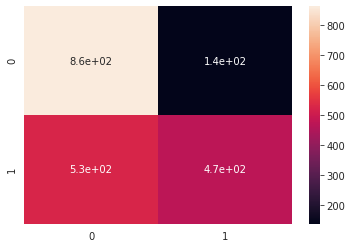

In [58]:
sns.heatmap(confusion_matrix(y_test,predict),annot=True)

Khá nhiều headline với is_sarcastic=0 được dự đoán đúng (khoảng 860 headlines). Và headline với is_sarcastic=1 dự đoán sai khá nhiều trong khi số lượng dự đoán đúng chỉ vào khoảng 470/1000 headline.

# **Dự đoán với bộ test 1000 câu sarcasm và 100 câu không sarcasm**

In [60]:
test2=pd.concat([data[data['is_sarcastic']==0][:1000],data[data['is_sarcastic']==1][:100]])
test2

,headlines,is_sarcastic
0,Trump Fires U.S. Attorney Who Led Probes Of Th...,0
1,6 Staffers Working On Trump's Tulsa Rally Test...,0
2,Community Wants Answers After LA Deputies Fata...,0
3,Police Arrest Peaceful Protester Sitting Alone...,0
4,Joe Biden Raised More Money Than Donald Trump ...,0
...,...,...
95,Trump Spends National Prayer Breakfast Attacki...,1
96,Sanders Makes Last-Minute Appeal To Moderates ...,1
97,Both Parties Acting Exactly How Everyone Expec...,1
98,Rush Limbaugh Admits Presidential Medal Of Fre...,1


In [62]:
feature=[]
for headline_ in test2['headlines']:
  feature.append(xuli_headline(headline_))

In [63]:
feature=tf.transform(feature)
feature

<1100x25608 sparse matrix of type '<class 'numpy.float64'>'
	with 7887 stored elements in Compressed Sparse Row format>

In [65]:
y_test=test2['is_sarcastic']

In [66]:

predict=loaded_model.predict(feature)

In [67]:
print(accuracy_score(y_test,predict))

0.8227272727272728


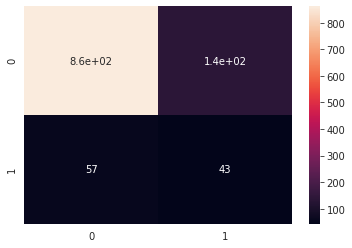

In [68]:
sns.heatmap(confusion_matrix(y_test,predict),annot=True)

Với độ chính xác khi dự đoán lên đến hơn 82%, trong 1000 not sarcastic headlines thì đã được dự đoán đúng lên đến 860 headlines và trong 100 sarcastic headlines thì chỉ dự đoán đúng được 43 headlines.

# **Dự đoán với bộ test 100 câu sarcasm và 1000 câu không sarcasm**

In [69]:
test3=pd.concat([data[data['is_sarcastic']==0][:100],data[data['is_sarcastic']==1][:1000]])
test3

,headlines,is_sarcastic
0,Trump Fires U.S. Attorney Who Led Probes Of Th...,0
1,6 Staffers Working On Trump's Tulsa Rally Test...,0
2,Community Wants Answers After LA Deputies Fata...,0
3,Police Arrest Peaceful Protester Sitting Alone...,0
4,Joe Biden Raised More Money Than Donald Trump ...,0
...,...,...
995,Amazing Detail: Every Game In MLB The Show W...,1
996,Everything You Need To Know About Nioh 2,1
997,Amazing Collaboration: NASA Is Working With Ni...,1
998,Amazing News Gamers: Everyone Is Having A Grea...,1


In [70]:
feature=[]
for headline_ in test3['headlines']:
  feature.append(xuli_headline(headline_))

In [72]:
feature=tf.transform(feature)
feature

<1100x25608 sparse matrix of type '<class 'numpy.float64'>'
	with 7410 stored elements in Compressed Sparse Row format>

In [73]:
y_test=test3['is_sarcastic']

In [74]:

predict=loaded_model.predict(feature)

In [75]:
print(accuracy_score(y_test,predict))

0.5018181818181818


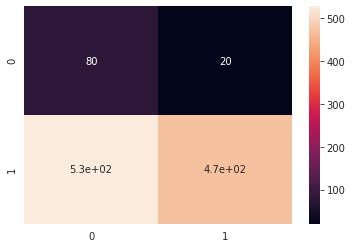

In [76]:
sns.heatmap(confusion_matrix(y_test,predict),annot=True)

Với độ chính xác khi dự đoán là 50,18%, trong 1000 sarcastic headlines thì đã được dự đoán đúng 470  headlines và trong 100 not sarcastic headlines thì dự đoán đúng được 80 headlines.

Qua 3 lần test trên ba dataset, chúng ta đã thấy model dự đoán khá tốt đối với not sarcastic headlines, nên chúng ta sẽ thấy accurency_score ở test2 sẽ cao hơn nhiều với ở test3